In [1]:
from marxslynx.lynx import PerfectLynx, conf

INFO: data files in version 0.0.dev27 (git hash 1ae512f402c9b8511b182d0043ac662e2c7a3143) [marxslynx.load_csv]
INFO: Loading data from /nfs/melkor/d1/guenther/soft/anaconda/envs/mayavi3/lib/python3.6/site-packages/marxslynx-0.0.dev27-py3.6.egg/marxslynx/data/gratings/Si_efficiency.dat [marxslynx.load_csv]


In [2]:
import numpy as np
from astropy.coordinates import SkyCoord
from marxs.source import PointSource, FixedPointing, JitterPointing
from marxs.utils import generate_test_photons
from marxs.simulator import Sequence

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
conf['grating_size'] = np.array([250., 250.])

In [5]:
n_photons = 1e4
instrument = PerfectLynx(conf)

In [6]:
instrument.elements[2].elements[0]._d

0.0002

In [7]:
len(instrument.elements[2].elements)

115

In [8]:
mysource = PointSource(coords=SkyCoord(0., 0., unit='deg'),
                           energy=0.5,
                           flux=1.)
fixedpointing = FixedPointing(coords=SkyCoord(0., 0., unit='deg'))
photons = mysource.generate_photons(n_photons)
photons = fixedpointing(photons)
photons = Sequence(elements=instrument.elements[:2])(photons)
p = Sequence(elements=instrument.elements[2:])(photons.copy())

    

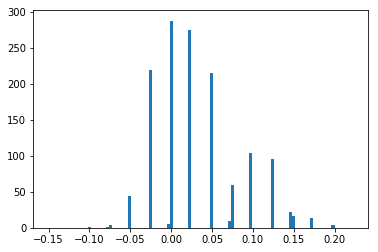

In [9]:
ind = np.isfinite(p['detcirc_phi'])
out = plt.hist(p['detcirc_phi'][ind], weights=p['probability'][ind], bins=100)

In [10]:
instrument.elements

 <function marxslynx.ralfgrating.catsupportbars(photons)>,

In [11]:
from marxslynx.bendgratings import NumericalChirpFinder, chirp_gratings

In [12]:
instrumchirp = PerfectLynx(conf)
opt = NumericalChirpFinder(instrument.elements[9], instrumchirp.elements[2].elements[0], order=-5, energy=0.5, d=0.0002)

In [13]:
chirp_gratings(instrumchirp.elements[2].elements, opt)

In [14]:
from marxs.optics import OrderSelector
from marxs.math.utils import e2h, h2e, norm_vector

In [15]:
from scipy.optimize import minimize_scalar

In [16]:
class ChirpFinder():
    uv = [0, 0]
    def __init__(self, detector, grat, order, energy, d=0.0002):
        self.photon = generate_test_photons(1)
        self.detector = detector
        self.grat = grat
        self.energy = energy
        self.order = order
        self.base_d = d
        self.calc_goal()
    def set_grat(self, grat):
        self.grat = grat
        self.calc_goal()
    def set_uv(self, uv):
        self.uv = uv
        self.init_photon()
    def calc_goal(self):
        self.grat.order_selector = OrderSelector([self.order])
        self.grat._d = self.base_d
        self.set_uv([0., 0.])
        self.run_photon()
        self.goal = self.photon['detcirc_phi'][0]
    def init_photon(self):
        posongrat = h2e(self.grat.geometry['center'] + 
                        self.uv[0] * self.grat.geometry['v_y'] + 
                        self.uv[1] * self.grat.geometry['v_z'])
        self.pos = e2h(1.1 * posongrat, 1)
        self.dir = norm_vector(- e2h(posongrat.reshape(1, 3), 0))
        self.reset_photon()
    def reset_photon(self):
        self.photon['pos'] = self.pos
        self.photon['dir'] = self.dir
        self.photon['probability'] = 1
    def run_photon(self):
        self.reset_photon()
        self.photon = self.grat(self.photon)
        self.photon = self.detector(self.photon)
    def optimize_func(self, d):
        self.grat._d = d * self.base_d
        self.run_photon()
        return np.abs(self.photon['detcirc_phi'][0] - self.goal)
        
    


In [17]:
instrumchirp = PerfectLynx(conf)
opt = ChirpFinder(instrument.elements[9], instrumchirp.elements[2].elements[0], order=-5, energy=0.5, d=0.0002)

In [18]:
res = np.zeros((len(instrumchirp.elements[2].elements), 3, 3))
for i, grat in enumerate(instrumchirp.elements[2].elements):
    if np.mod(i, 10) == 0:
        print(i)
    opt.set_grat(grat)
    for j, u in enumerate(np.linspace(-.99, .99, res.shape[1])):
        #for k, v in enumerate(np.linspace(-.99, .99, res.shape[2])):
        for k, v in enumerate([0.]):
            opt.set_uv([u, v])
            res[i, j, k] = minimize_scalar(opt.optimize_func, bracket=(.99, 1., 1.01)).x
            
    ly = np.linalg.norm(grat.geometry['v_y'])
    lz = np.linalg.norm(grat.geometry['v_z'])
    grat.spline = RectBivariateSpline(
                        ly * np.linspace(-.99, .99, res.shape[1]), 
                        lz * np.linspace(-.99, .99, res.shape[2]), 
                        0.0002 * dbetter[i, :, :],
                        bbox=[-ly, ly, -lz, lz],
                        kx=2, ky=2)
    grat.interpy = 0.0002 * np.array([dbetter[i, 0, 0], dbetter[i, 2, 0]], copy=True)
    def func(self, intercoos):
        return self.spline(intercoos[:, 0], intercoos[:, 1], grid=False)
    #def func(self, intercoos):
    #    return np.interp(intercoos[:, 0],
    #                     ly * np.array([-.99, .99]), 
    #                     self.interpy)
    # Invoking the descriptor protocol to create a bound method
    # see https://stackoverflow.com/questions/972/adding-a-method-to-an-existing-object-instance
    grat._d = func.__get__(grat)
            
instrumchirp = PerfectLynx(conf)
dbetter = res
# In current experiment, only first column is filled with values
dbetter[:, :, 1] = dbetter[:, :, 0]
dbetter[:, :, 2] = dbetter[:, :, 0]
#dbetter = np.ones_like(res)
for i, grat in enumerate(instrumchirp.elements[2].elements):


SyntaxError: unexpected EOF while parsing (<ipython-input-18-37811a20b4d6>, line 37)

In [ ]:
epos = np.stack(instrument.elements[2].elem_pos)
plt.scatter(epos[:, 1, 3], epos[:, 2, 3]), c = res[:, 0,0])
plt.colorbar()

In [ ]:
from scipy.interpolate import RectBivariateSpline

In [ ]:
instrumchirp = PerfectLynx(conf)
dbetter = res
# In current experiment, only first column is filled with values
dbetter[:, :, 1] = dbetter[:, :, 0]
dbetter[:, :, 2] = dbetter[:, :, 0]
#dbetter = np.ones_like(res)
for i, grat in enumerate(instrumchirp.elements[2].elements):
    ly = np.linalg.norm(grat.geometry['v_y'])
    lz = np.linalg.norm(grat.geometry['v_z'])
    grat.spline = RectBivariateSpline(
                        ly * np.linspace(-.99, .99, res.shape[1]), 
                        lz * np.linspace(-.99, .99, res.shape[2]), 
                        0.0002 * dbetter[i, :, :],
                        bbox=[-ly, ly, -lz, lz],
                        kx=2, ky=2)
    grat.interpy = 0.0002 * np.array([dbetter[i, 0, 0], dbetter[i, 2, 0]], copy=True)
    def func(self, intercoos):
        return self.spline(intercoos[:, 0], intercoos[:, 1], grid=False)
    #def func(self, intercoos):
    #    return np.interp(intercoos[:, 0],
    #                     ly * np.array([-.99, .99]), 
    #                     self.interpy)
    # Invoking the descriptor protocol to create a bound method
    # see https://stackoverflow.com/questions/972/adding-a-method-to-an-existing-object-instance
    grat._d = func.__get__(grat)

In [ ]:
ly * np.array([-.99, .99])

In [ ]:

chirprunner = Sequence(elements=instrumchirp.elements[2:])
pchirp = chirprunner(photons.copy())

In [ ]:
ind = p['order'] == -5
plt.plot(p['detcirc_phi'][ind], p['detcirc_y'][ind], '.')
ind = pchirp['order'] == -5
plt.plot(pchirp['detcirc_phi'][ind], pchirp['detcirc_y'][ind], '.')
#plt.xlim([.12284, .1229])
#plt.ylim([-0.2, 0.2])
ind.sum()

In [ ]:
bins = np.linspace(-0.0014, -0.0009, 50)
ind = p['order'] == -5
out = plt.hist(p['detcirc_phi'][ind], weights=p['probability'][ind], bins=bins, label='p')
print(np.std(p['detcirc_phi'][ind]))
ind = pchirp['order'] == -5
out = plt.hist(pchirp['detcirc_phi'][ind], weights=pchirp['probability'][ind], bins=bins, histtype='step', label='chirp')
print(np.std(pchirp['detcirc_phi'][ind]))
plt.legend()

In [ ]:
ind = p['order'] == -5
plt.plot(p['detcirc_phi'][ind], p['grat_y'][ind], '.')
ind = pchirp['order'] == -5
plt.plot(pchirp['detcirc_phi'][ind], pchirp['grat_y'][ind], '.')

In [ ]:
instrument = PerfectLynx(conf)
p5runner = Sequence(elements=instrument.elements[2:])
for e in p5runner.elements[0].elements:
    e.order_selector = OrderSelector([-5])
p5 = p5runner(photons.copy())
chirp5runner = Sequence(elements=instrumchirp.elements[2:])
for e in chirp5runner.elements[0].elements:
    e.order_selector = OrderSelector([-5])
pchirp5 = chirp5runner(photons.copy())

In [ ]:
from astropy.table import Table, join
facets = Table({'facet': np.arange(len(instrument.elements[2].elements)), 
                'facet_x':epos[:, 0, 3], 'facet_y': epos[:, 1, 3], 'facet_z':epos[:, 2, 3]})
p5 = join(p5, facets)
pchirp5 = join(pchirp5, facets)

In [ ]:
p5.colnames

In [ ]:
plt.scatter(pchirp5['detcirc_phi'], pchirp5['grat_y'], c=p5['facet_y'])
plt.xlim(-0.0014, -0.0008)
plt.colorbar()

In [ ]:
plt.scatter(p5['detcirc_phi'], p5['grat_y'], c=p5['facet_y'])
plt.xlim(-0.0014, -0.0008)
plt.colorbar()

In [ ]:
from marxs.analysis.gratings import resolvingpower_from_photonlist

In [ ]:
res0, pos0, std0 = resolvingpower_from_photonlist(p, np.arange(-8, 1), col='detcirc_phi')

In [ ]:
resc, posc, stdc = resolvingpower_from_photonlist(pchirp, np.arange(-8, 1), col='detcirc_phi')

In [ ]:
plt.plot(np.arange(-8, 1), res0)
plt.plot(np.arange(-8, 1), resc)